In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D, Flatten
from tensorflow import keras
from tqdm import tqdm

fp = 'data/preprocessed_filled.csv'
info_fp = 'data/series.csv'
df = pd.read_csv(fp, low_memory=False)
info_df = pd.read_csv(info_fp)

df.head()

,date,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,...,PCUOMINOMIN,SFTPAGRM158SFRBSF,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD,value
0,2010-02-14,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,47.17,NaN
1,2010-02-15,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,60.68,NaN
2,2010-02-16,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,15.89,NaN
3,2010-02-17,1.72,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,...,219.8,0.197947,2.28,0.15,11722.007,10398.525000,105.5,9.9,11.96,NaN
4,2010-02-18,1.70,95.5,2.72,49870.0,-2.29,11460.0,-9.62,45.9,6.8330,...,219.8,0.197947,2.31,0.15,11725.610,10401.326571,105.5,9.9,30.14,NaN


In [39]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
df.rename(columns={'date': 'Date'}, inplace=True)
df.rename(columns={'value': 'SP500'}, inplace=True)
df.to_csv('data/cleaned_no_multiindex.csv')

In [6]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
df.drop(columns='Date', inplace=True)
df.head()

,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,PCUOMINOMIN,SFTPAGRM158SFRBSF,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD,SP500
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-14,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,1.3742,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,47.17,NaN
2010-02-15,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,1.3742,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,60.68,NaN
2010-02-16,1.73,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,1.3742,...,219.8,0.197947,2.24,0.15,11722.007,10398.525000,105.5,9.9,15.89,NaN
2010-02-17,1.72,95.5,2.73,49870.0,-2.29,11460.0,-9.62,45.9,6.8326,1.3623,...,219.8,0.197947,2.28,0.15,11722.007,10398.525000,105.5,9.9,11.96,NaN
2010-02-18,1.70,95.5,2.72,49870.0,-2.29,11460.0,-9.62,45.9,6.8330,1.3563,...,219.8,0.197947,2.31,0.15,11725.610,10401.326571,105.5,9.9,30.14,NaN


In [7]:
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [ ]:
df_scaled.isna().sum().sum()

# One Year Time Window

In [130]:
one_week = pd.to_timedelta('1w')
one_month = pd.to_timedelta('30d')  # room to make it more precise?
one_year = pd.to_timedelta('1y')

# CHANGE FOR DIFFERENT TIME HORIZONS
horizon = one_month

n_train_days = 365 * 5
train = df_scaled.iloc[:n_train_days, :]
val = df_scaled.iloc[n_train_days:, :]

y_train = train['SP500'].dropna()
X_train = y_train.reset_index()['Date'].apply(
    lambda x: train.drop('SP500', axis=1).loc[
        (train.drop('SP500', axis=1).index>=x-horizon) & 
        (train.drop('SP500', axis=1).index<x)].values)

y_val = val['SP500'].dropna()
X_val = y_val.reset_index()['Date'].apply(
    lambda x: df_scaled.drop('SP500', axis=1).loc[
        (df_scaled.drop('SP500', axis=1).index>=x-horizon) & 
        (df_scaled.drop('SP500', axis=1).index<x)].values)

In [131]:
X_train = np.stack(X_train)
X_val = np.stack(X_val.values)

## Vanilla LSTM

Train on 1044 samples, validate on 751 samples
Epoch 1/150
1044/1044 - 18s - loss: 0.3918 - val_loss: 0.4056
Epoch 2/150
1044/1044 - 1s - loss: 0.5186 - val_loss: 0.4993
Epoch 3/150
1044/1044 - 1s - loss: 0.0629 - val_loss: 0.4896
Epoch 4/150
1044/1044 - 1s - loss: 0.0347 - val_loss: 0.4591
Epoch 5/150
1044/1044 - 1s - loss: 0.0188 - val_loss: 0.4519
Epoch 6/150
1044/1044 - 1s - loss: 0.0135 - val_loss: 0.4455
Epoch 7/150
1044/1044 - 1s - loss: 0.0113 - val_loss: 0.4362
Epoch 8/150
1044/1044 - 1s - loss: 0.0097 - val_loss: 0.4275
Epoch 9/150
1044/1044 - 1s - loss: 0.0085 - val_loss: 0.4224
Epoch 10/150
1044/1044 - 1s - loss: 0.0078 - val_loss: 0.4171
Epoch 11/150
1044/1044 - 1s - loss: 0.0075 - val_loss: 0.4150
Epoch 12/150
1044/1044 - 1s - loss: 0.0083 - val_loss: 0.4098
Epoch 13/150
1044/1044 - 1s - loss: 0.0118 - val_loss: 0.4113
Epoch 14/150
1044/1044 - 1s - loss: 0.0239 - val_loss: 0.4002
Epoch 15/150
1044/1044 - 1s - loss: 0.0563 - val_loss: 0.4075
Epoch 16/150
1044/1044 - 1s - l

Epoch 132/150
1044/1044 - 1s - loss: 0.0018 - val_loss: 0.3243
Epoch 133/150
1044/1044 - 1s - loss: 0.0018 - val_loss: 0.3245
Epoch 134/150
1044/1044 - 1s - loss: 0.0018 - val_loss: 0.3247
Epoch 135/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3249
Epoch 136/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3251
Epoch 137/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3253
Epoch 138/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3254
Epoch 139/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3256
Epoch 140/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3258
Epoch 141/150
1044/1044 - 1s - loss: 0.0017 - val_loss: 0.3259
Epoch 142/150
1044/1044 - 1s - loss: 0.0016 - val_loss: 0.3261
Epoch 143/150
1044/1044 - 1s - loss: 0.0016 - val_loss: 0.3262
Epoch 144/150
1044/1044 - 1s - loss: 0.0016 - val_loss: 0.3263
Epoch 145/150
1044/1044 - 1s - loss: 0.0016 - val_loss: 0.3264
Epoch 146/150
1044/1044 - 1s - loss: 0.0016 - val_loss: 0.3265
Epoch 147/150
1044/1044 - 1s - loss: 0.0016 - val_loss:

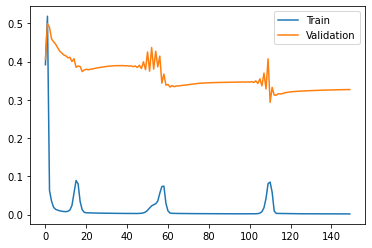

In [136]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mae', optimizer=opt)
history = model.fit(X_train, y_train, epochs=30, batch_size=72, validation_data=(X_val, y_val), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

## LSTM Encoder-Decoder

In [128]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(1))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mae', optimizer=opt)
history2_year = model.fit(X_train, y_train, epochs=30, batch_size=72, validation_data=(X_val, y_val), verbose=2, shuffle=False)

# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Validation')
# plt.legend()
# plt.show()

Train on 1044 samples, validate on 751 samples
Epoch 1/30
1044/1044 - 15s - loss: 0.7955 - val_loss: 0.9842
Epoch 2/30
1044/1044 - 0s - loss: 0.7366 - val_loss: 0.9782
Epoch 3/30
1044/1044 - 0s - loss: 0.6662 - val_loss: 0.9706
Epoch 4/30
1044/1044 - 0s - loss: 0.5453 - val_loss: 0.9600
Epoch 5/30
1044/1044 - 0s - loss: 0.3048 - val_loss: 0.9382
Epoch 6/30
1044/1044 - 0s - loss: 0.2137 - val_loss: 0.8993
Epoch 7/30
1044/1044 - 0s - loss: 0.3121 - val_loss: 0.8708
Epoch 8/30
1044/1044 - 0s - loss: 0.1627 - val_loss: 0.8309
Epoch 9/30
1044/1044 - 0s - loss: 0.1873 - val_loss: 0.7754
Epoch 10/30
1044/1044 - 0s - loss: 0.1498 - val_loss: 0.7168
Epoch 11/30
1044/1044 - 0s - loss: 0.1416 - val_loss: 0.6569
Epoch 12/30
1044/1044 - 0s - loss: 0.1464 - val_loss: 0.6415
Epoch 13/30
1044/1044 - 0s - loss: 0.1316 - val_loss: 0.6016
Epoch 14/30
1044/1044 - 0s - loss: 0.1319 - val_loss: 0.5884
Epoch 15/30
1044/1044 - 0s - loss: 0.1240 - val_loss: 0.5591
Epoch 16/30
1044/1044 - 0s - loss: 0.1259 - va

## ConvLSTM

In [91]:
X_train = X_train.reshape(X_train.shape[0], 1, 1, 7, 64)
X_val = X_val.reshape(X_val.shape[0], 1, 1, 7, 64)

In [92]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,6), activation='relu', input_shape=(1, 1, 7, 64)))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(500, activation='relu')))
model.add(TimeDistributed(Dense(1)))
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mae', optimizer=opt)
history3_week = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), verbose=2, shuffle=False)

# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Validation')
# plt.legend()
# plt.show()

Train on 1044 samples, validate on 751 samples
Epoch 1/30
1044/1044 - 16s - loss: 0.8084 - val_loss: 0.9308
Epoch 2/30
1044/1044 - 0s - loss: 0.7925 - val_loss: 0.9328
Epoch 3/30
1044/1044 - 0s - loss: 0.7768 - val_loss: 0.9335
Epoch 4/30
1044/1044 - 0s - loss: 0.7545 - val_loss: 0.9331
Epoch 5/30
1044/1044 - 0s - loss: 0.7202 - val_loss: 0.9312
Epoch 6/30
1044/1044 - 0s - loss: 0.6650 - val_loss: 0.9268
Epoch 7/30
1044/1044 - 0s - loss: 0.5736 - val_loss: 0.9185
Epoch 8/30
1044/1044 - 0s - loss: 0.4202 - val_loss: 0.9046
Epoch 9/30
1044/1044 - 0s - loss: 0.2436 - val_loss: 0.8794
Epoch 10/30
1044/1044 - 0s - loss: 0.2145 - val_loss: 0.8378
Epoch 11/30
1044/1044 - 0s - loss: 0.1733 - val_loss: 0.7902
Epoch 12/30
1044/1044 - 0s - loss: 0.1586 - val_loss: 0.7339
Epoch 13/30
1044/1044 - 0s - loss: 0.1512 - val_loss: 0.6735
Epoch 14/30
1044/1044 - 0s - loss: 0.1468 - val_loss: 0.6287
Epoch 15/30
1044/1044 - 0s - loss: 0.1412 - val_loss: 0.6242
Epoch 16/30
1044/1044 - 0s - loss: 0.1373 - va

## Build Pairplot

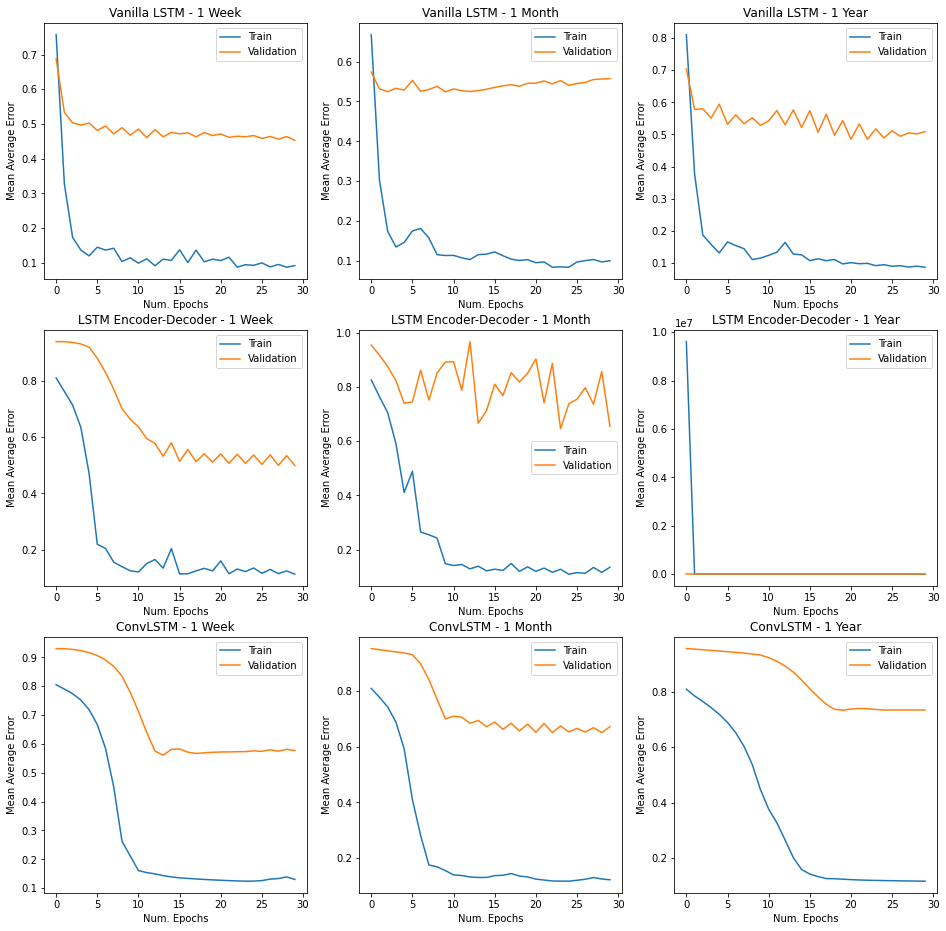

In [86]:
hists = [history1_week, history1_month, history1_year,
         history2_week, history2_month, history2_year,
         history3_week, history3_month, history3_year]

periods = ['1 Week', '1 Month', '1 Year']
models  = ['Vanilla LSTM', 'LSTM Encoder-Decoder', 'ConvLSTM']

fig, axes = plt.subplots(3,3, figsize=(16,16))
for i, hist in enumerate(hists):
    ax = axes[i//3][i%3]
    ax.plot(hist.history['loss'], label='Train')
    ax.plot(hist.history['val_loss'], label='Validation')
    ax.set_title(f'{models[i//3]} - {periods[i%3]}')
    ax.set_xlabel('Num. Epochs')
    ax.set_ylabel('Mean Average Error')
    ax.legend()
    
plt.savefig('models_pairplot.png', transparent=True)


In [103]:
weights = model.get_weights()

In [104]:
len(weights)

5

In [129]:
vals = tuple(zip(train.columns, weights[0].mean(1)))
sorted(vals, key=lambda x:abs(x[1]), reverse=True)[:10]


[('T10YIE', -0.03472059),
 ('GVIPT52100S', -0.029276382),
 ('PCUAINFOAINFO', -0.025145087),
 ('PCUATRANSATRANS', -0.02502439),
 ('PCUAMUMAMUM', -0.023975473),
 ('PCUOMINOMIN', -0.02183712),
 ('WLEMUINDXD', 0.021016462),
 ('AAA10Y', 0.019060876),
 ('GVIPT52000S', -0.018959947),
 ('TSIFRGHT', -0.018778091)]

In [141]:
pd.to_datetime(pd.read_csv('data/observations_test.csv').date).describe(datetime_is_numeric=True)

count                            23229
mean     2019-07-10 08:47:58.884163840
min                2018-01-02 00:00:00
25%                2018-10-07 00:00:00
50%                2019-07-05 00:00:00
75%                2020-04-03 00:00:00
max                2021-02-12 00:00:00
Name: date, dtype: object

In [162]:
test = pd.read_csv('data/observations_test.csv')
test[test.series_id=='SP500'].date.nunique()

0

In [171]:
test = pd.read_csv('data/SPY.csv')
test = test.set_index('Date')
spy_test = test.Close.rename('SP500')[1:].to_frame()
spy_test

,SP500
Date,
2018-02-02,275.450012
2018-02-05,263.929993
2018-02-06,269.130005
2018-02-07,267.670013
2018-02-08,257.630005
...,...
2021-02-08,390.510010
2021-02-09,390.250000
2021-02-10,390.079987


In [185]:
spy_test

,SP500,week,month,year
Date,,,,
2018-02-02,275.450012,267.289150,265.469911,275.571238
2018-02-05,263.929993,261.043931,271.619707,274.241550
2018-02-06,269.130005,262.629356,262.266105,270.785068
2018-02-07,267.670013,270.811243,257.837885,276.661859
2018-02-08,257.630005,250.378551,244.196192,274.594822
...,...,...,...,...
2021-02-08,390.510010,398.179876,377.451875,395.127310
2021-02-09,390.250000,391.206875,384.116268,390.230061
2021-02-10,390.079987,386.758196,387.963291,378.015284


In [217]:
spy_test.drop('SP500', 1).to_csv('predictions.csv')

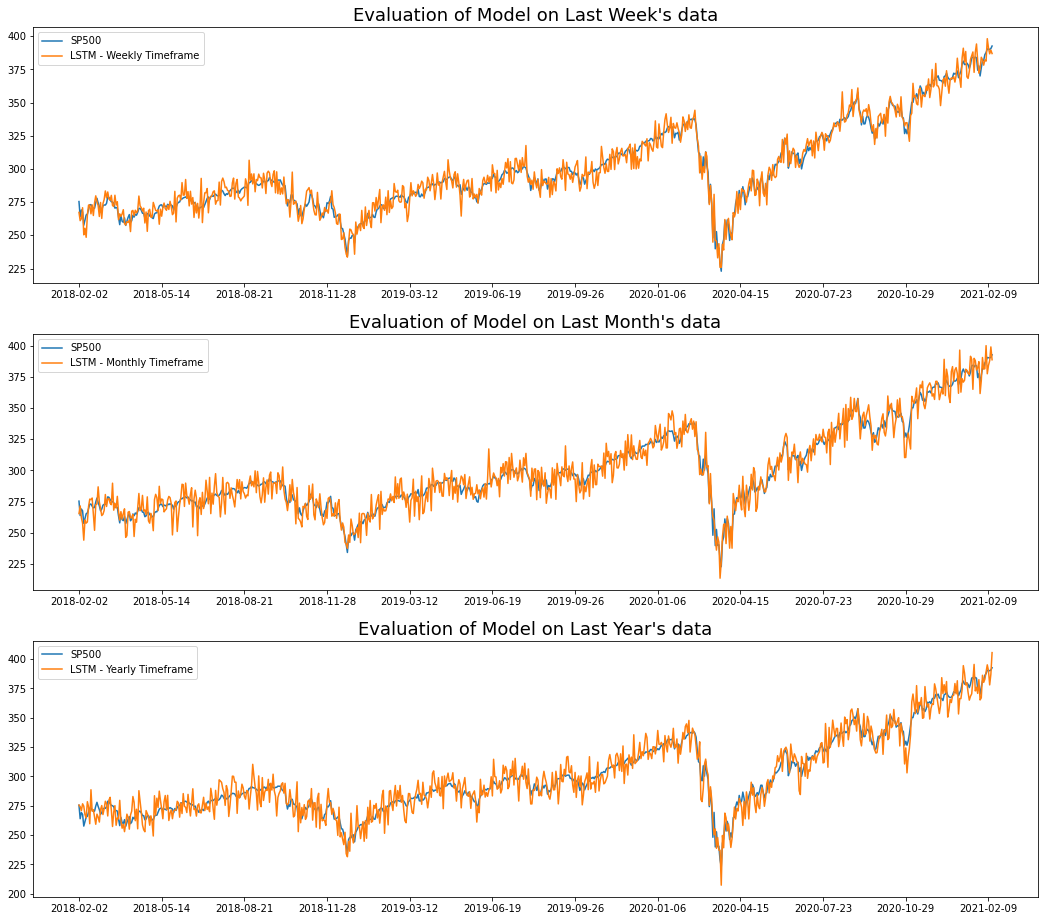

In [214]:
fig, ax = plt.subplots(3,1, figsize=(18, 16))
ax[0].plot(spy_test.SP500, label='SP500')
ax[0].plot(spy_test.week, label='LSTM - Weekly Timeframe')
ax[0].set_xticks(range(0, 763, 69));
ax[0].set_title("Evaluation of Model on Last Week's data", fontsize=18)
ax[0].legend();

ax[1].plot(spy_test.SP500, label='SP500')
ax[1].plot(spy_test.month, label='LSTM - Monthly Timeframe')
ax[1].set_title("Evaluation of Model on Last Month's data", fontsize=18)
ax[1].set_xticks(range(0, 763, 69));
ax[1].legend();

ax[2].plot(spy_test.SP500, label='SP500')
ax[2].plot(spy_test.year, label='LSTM - Yearly Timeframe')
ax[2].set_xticks(range(0, 763, 69));
ax[2].set_title("Evaluation of Model on Last Year's data", fontsize=18)
ax[2].legend();

fig.savefig('model_performance.png', transparent=True)